   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

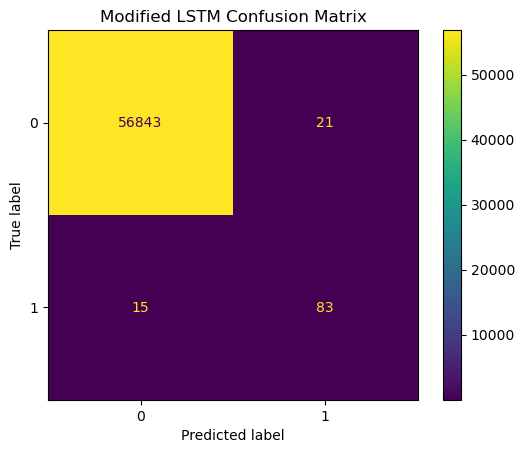

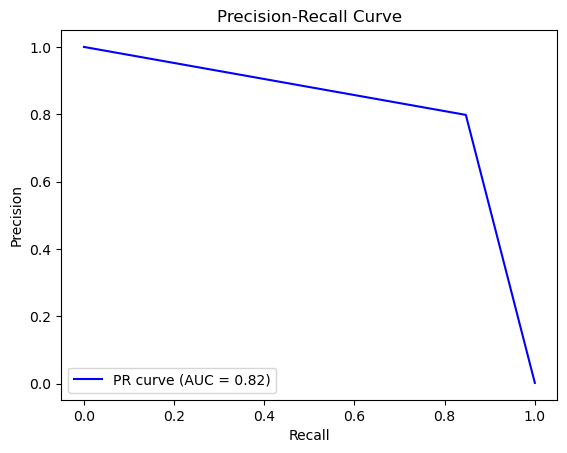

Accuracy: 0.9994
Precision: 0.7981
Recall: 0.8469
F1-Score: 0.8218


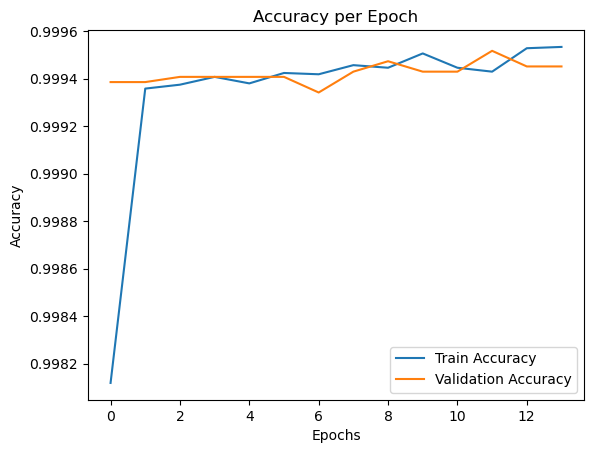

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, precision_score, recall_score, f1_score, accuracy_score

# Load data
df = pd.read_csv('C:/Users/Admin/Desktop/creditcard.csv')  # Update path if needed
print(df.head())

# Data Preprocessing
scaler = StandardScaler()
X = df.drop(columns=['Class'])  # Features
y = df['Class']  # Target

X_scaled = scaler.fit_transform(X)  # Normalize features
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # Reshape for LSTM

# Split into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Samples: {X_train.shape}, Test Samples: {X_test.shape}")

# Learning Rate Schedule (Cyclic Learning Rate)
def cyclical_learning_rate(epoch, lr_max=0.01, lr_min=0.0001, stepsize=2000):
    cycle = np.floor(1 + epoch / (2 * stepsize))
    x = np.abs(epoch / stepsize - 2 * cycle + 1)
    lr = lr_min + (lr_max - lr_min) * max(0, (1 - x))
    return lr

# Modified LSTM Architecture with Enhancements
def build_modified_lstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        SpatialDropout1D(0.3),  # Spatial Dropout
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        SpatialDropout1D(0.2),  # Spatial Dropout
        LSTM(32),
        Dense(64, activation='relu'),  # Additional Dense layer for better feature fusion
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=AdamW(learning_rate=0.001),
        loss='binary_crossentropy',  # Standard binary crossentropy loss
        metrics=['accuracy']
    )
    
    return model

# Train Modified LSTM Model with Cyclic Learning Rate
modified_lstm = build_modified_lstm((X_train.shape[1], X_train.shape[2]))

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    LearningRateScheduler(cyclical_learning_rate, verbose=1)  # Applying cyclic learning rate
]

history_modified = modified_lstm.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate Modified LSTM
y_pred_modified = (modified_lstm.predict(X_test) > 0.5).astype(int).flatten()

# Metrics
print("\nModified LSTM Performance:")

# Classification Report
print(classification_report(y_test, y_pred_modified))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_modified)
print(f"ROC-AUC Score: {roc_auc}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_modified)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title("Modified LSTM Confusion Matrix")
plt.show()

# Precision-Recall Curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_modified)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='b', label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred_modified)
print(f"Accuracy: {accuracy:.4f}")

# Precision Score
precision = precision_score(y_test, y_pred_modified)
print(f"Precision: {precision:.4f}")

# Recall Score
recall = recall_score(y_test, y_pred_modified)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred_modified)
print(f"F1-Score: {f1:.4f}")

# Accuracy per epoch plot
plt.plot(history_modified.history['accuracy'], label='Train Accuracy')
plt.plot(history_modified.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


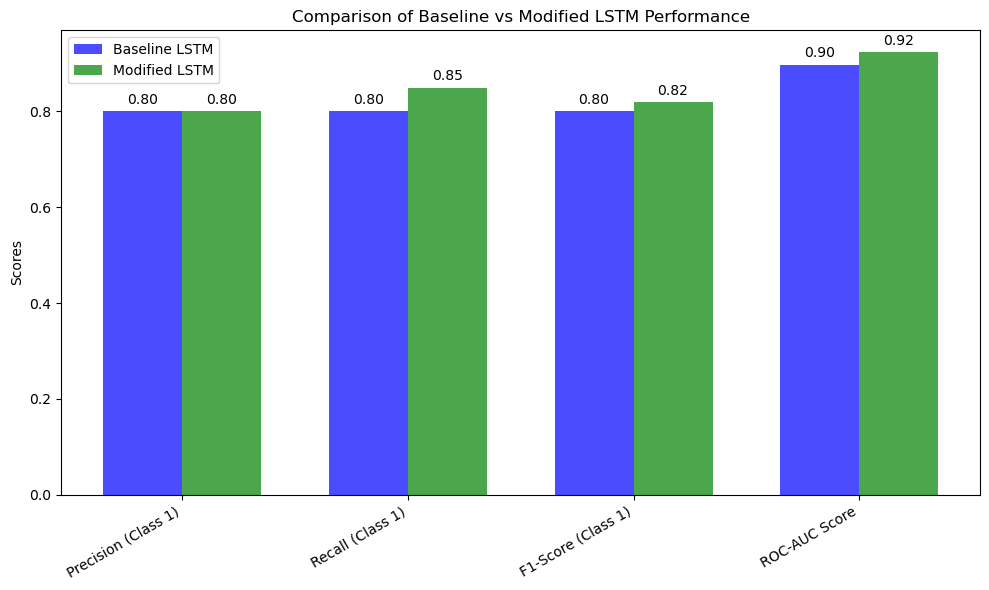

In [3]:
 import matplotlib.pyplot as plt
import numpy as np

# Metrics for Baseline and Modified LSTM
categories = ["Precision (Class 1)", "Recall (Class 1)", "F1-Score (Class 1)", "ROC-AUC Score"]
baseline_values = [0.80, 0.80, 0.80, 0.8978]
modified_values = [0.80, 0.85, 0.82, 0.9233]

x = np.arange(len(categories))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars
bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline LSTM', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, modified_values, width, label='Modified LSTM', color='green', alpha=0.7)

# Labels and formatting
ax.set_ylabel('Scores')
ax.set_title('Comparison of Baseline vs Modified LSTM Performance')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=30, ha="right")
ax.legend()

# Display values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


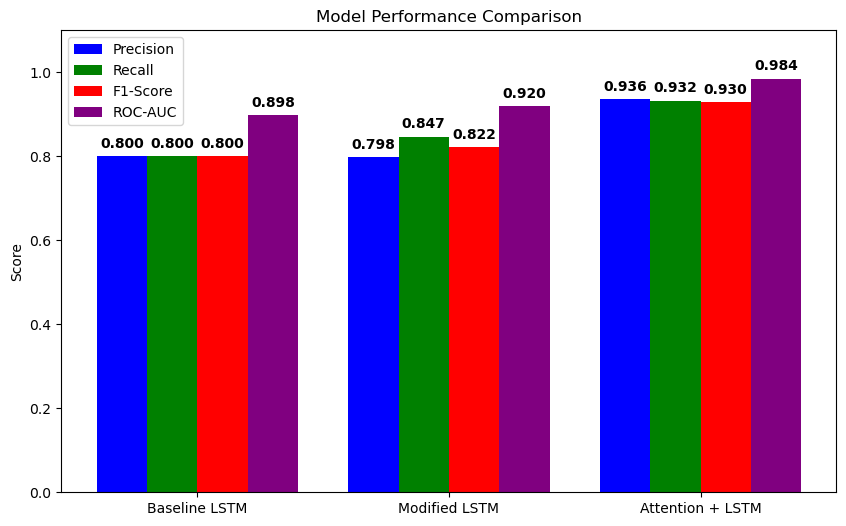

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics for each model
models = ["Baseline LSTM", "Modified LSTM", "Attention + LSTM"]
precision = [0.80, 0.7981, 0.9360]
recall = [0.80, 0.8469, 0.9323]
f1_score = [0.80, 0.8218, 0.929592]  # Calculating F1-score for Attention + LSTM
roc_auc = [0.8978, 0.92, 0.9844]

# Bar width and positions
x = np.arange(len(models))
width = 0.2  

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
bars1 = ax.bar(x - 1.5*width, precision, width, label="Precision", color="blue")
bars2 = ax.bar(x - 0.5*width, recall, width, label="Recall", color="green")
bars3 = ax.bar(x + 0.5*width, f1_score, width, label="F1-Score", color="red")
bars4 = ax.bar(x + 1.5*width, roc_auc, width, label="ROC-AUC", color="purple")

# Function to add value labels above bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.3f}', ha='center', fontsize=10, fontweight='bold')

# Add value labels above bars
add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel("Score")
ax.set_ylim(0, 1.1)
ax.set_title("Model Performance Comparison")
ax.legend()

plt.show() 